In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
data = pd.read_csv("fer2013.csv")

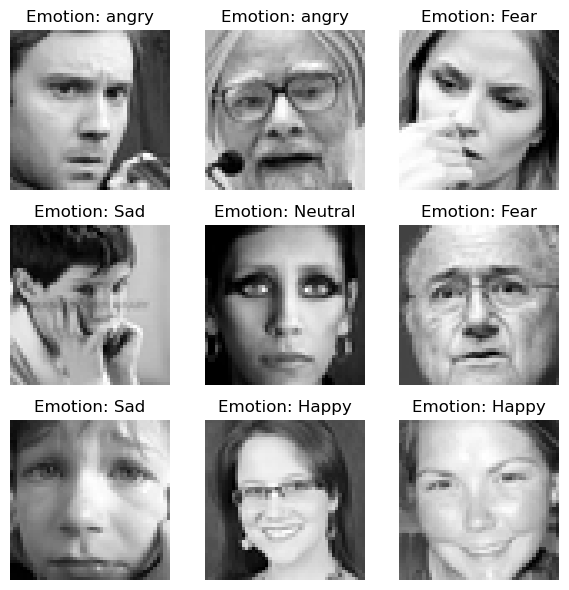

In [49]:
#convert pixels to images
labels = {0: "angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "surprized", 6: "Neutral"}


data_subset = data.iloc[:9]

# Create a figure with subplots for a 2x2 grid
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

images = []
# Process each image and display in a subplot
for i, row in data_subset.iterrows():
    pixels = np.array(row['pixels'].split(' '), dtype='float32')
    pixels = pixels.reshape(48, 48)

    images.append(pixels)
    # Adjust axes index based on subplot layout (0-indexed)
    ax = axes.flat[i]  # Access the correct subplot for current iteration

    ax.imshow(pixels, cmap='gray')
    ax.set_title(f"Emotion: {labels[row['emotion']]}")
    ax.axis('off')

# Tight layout to prevent overlapping labels and titles
plt.tight_layout()
plt.show()


# Model training

In [50]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import tqdm
from torch import optim

In [51]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=7):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels= in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 12* 12, 128)
        self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 12 *12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Data preparation

In [92]:
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset

class FER2013Dataset(Dataset):

    def __init__(self, data_frame, transform=None):
        self.data_frame = data_frame
        self.transform = transform
    def __len__(self):
        return len(self.data_frame)
    def __getitem__(self, idx):
        image = self.data_frame.iloc[idx, 1:].values.reshape(48, 48).astype("uint8")
        label = self.data_frame.iloc[idx, 0]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data splitting

In [93]:
training_data = data[data["Usage"] == "Training"]
validation_data = data[data['Usage'] == "PublicTest"]
testing_data = data[data['Usage'] == "PrivateTest"]

In [94]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [95]:
input_size = 784  # 28x28 pixels (not directly used in CNN)
num_classes = 10  # digits 0-9
learning_rate = 0.001
batch_size = 64
num_epochs = 10 

# Data transformation

In [96]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

training_dataset = FER2013Dataset(data_frame=training_data, transform=transform)
validation_dataset = FER2013Dataset(data_frame=validation_data, transform=transform)
testing_dataset = FER2013Dataset(data_frame=testing_data, transform=transform)

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testing_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [97]:
model = CNN(in_channels=1, num_classes=num_classes).to(device)

creation = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for image, labels in tqdm.tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(image)
        loss = creation(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch: [{epoch}/{num_epochs}], loss: {running_loss/len(train_loader)}: .4f')

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = creation(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Validation Loss: {val_loss/len(validation_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')
    

  0%|          | 0/449 [00:00<?, ?it/s]


ValueError: cannot reshape array of size 2 into shape (48,48)